In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [38]:
%pip install xlsxwriter
   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 2.1 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Take a sample of 10 data sample
#shuffle the data around - because the system rows are not completely random
df = pd.read_parquet('python_code.parquet')


### Exploring the 506k value dataset

The original dataset has around 506k rows. There are three columns: 'output', 'instruction', and 'system'. The values in the system are the most repetitive across all the data values and here I want to find out how many unique type of systems there are. And what type of systems could be the most interesting to use. 

Notes:
Finding out how many unique systems there are and which ones occur the most.
After browsing through the dataset, the system value that starts with 'Below...' is the most common, so I combined all the counts of the system value that has that prefix. 
I ordered the systems by the most occurances. 

Findings: 

Out of 506k rows there are: 
- 978 unique systems
- 767 unique systems that occur more than once
- 9 systems that occur more than 10,000 times
- 13 systems that occur more than 1000 times
- 16 systems that occur more than 100 times
- systems of freq 2000 - 3000 are general code assist systems
- systems of freq 300 - 400 are general code translation systems (maybe we can combine them?)
- systems of freq less than 100: did not look through them carefully. 

When we are sampling data for our project, we can take equal shares of each of the most common system type. 


In [3]:
#how many of each in the whole dataset -> parse a few of them

#preprocess rows starting with the following prefix. Just parse the prefix.  
prefix = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.'
count = df[df['system'].str.startswith(prefix)].shape[0]
prefix_count_df = pd.DataFrame({'system': [f'Starting with "{prefix}"'], 'count': [count]}) #dataframe of just this row

#number of other unique systems
remaining_counts = df[~df['system'].str.startswith(prefix)].groupby('system').size().reset_index(name='count')

#Dataframe with count of all unique systems
result_unique = pd.concat([prefix_count_df, remaining_counts], ignore_index=True)

#Filter out the systems that only occur once
filtered_remaining_counts = remaining_counts[remaining_counts['count'] > 1]
#Data frame with only systems that occur more than once
result_g1 = pd.concat([prefix_count_df, filtered_remaining_counts], ignore_index=True).sort_values(by='count', ascending=False).reset_index(drop=True)

#only count the system values that have greater than 50 occurances
filtered_remaining_counts_50 = remaining_counts[remaining_counts['count'] > 100]
# Dataframe with only systems that occur more than 50 times
result_g50 = pd.concat([prefix_count_df, filtered_remaining_counts_50], ignore_index=True)


pd.set_option('display.max_colwidth', None)  # Ensure full content is displa
pd.set_option('display.max_rows', None)      # Show all rows
# Print result
print(len(result_unique))
print(len(result_g50)) #what is the system with the largest count, draw a histogram with the remaining. 
print(result_g1.head(17)) #top 17 occurances of systems types


978
16
                                                                                                                       system  \
0   Starting with "Below is an instruction that describes a task. Write a response that appropriately completes the request."   
1                                             As a Python code translator, you convert algorithms and pseudocode into Python.   
2                                               You are a Python code analyst, evaluating scripts for potential improvements.   
3                                                As a Python code analyst, you investigate and solve complex coding mysteries   
4                                                           As a Python code composer, you craft elegant and concise scripts.   
5                                           As a python code expert, you are capable of creating scripts from specifications.   
6                                           You are a Python code generator, capable of cr

#### Other details

1. Inputs for `Instruction` can be either entirely code, entirely words, or a combination. 
    - For preprocessing, we can filter them out by system. 
2. The `Outputs` are also either entirely code or a combination of an explanation and the code. 
    - Further preprocessing for the output data may be needed so that we can extract only the code version. 

### Sampling the 10 random rows of data and exploring them

In [27]:
df = df.sample(frac=1, random_state=1).reset_index(drop=True) #shuffle data around, because the data is sorted by system
sample_data = df.sample(n=10, random_state=1)
prefix = "Below is an instruction that describes a task. Write a response that appropriately completes the request."

sample_data['system'] = sample_data['system'].apply(
    lambda x: "Instruction, write response" if x.startswith(prefix) else x
)

In [39]:
with pd.ExcelWriter("random_preprocessed_data_yuwati.xlsx", engine='xlsxwriter') as writer:
    # Write the DataFrame to the specified Excel file
    sample_data.to_excel(writer, sheet_name='Sheet1', index=False)

    # Access the XlsxWriter workbook and worksheet objects
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']

    # Define a format for text wrapping
    wrap_format = workbook.add_format({'text_wrap': True})

    # Set the column width and apply the wrap format to each column
    worksheet.set_column('A:A', 40, wrap_format)  # Adjust width and wrap for Column1
    worksheet.set_column('B:B', 40, wrap_format)  
    worksheet.set_column('C:C', 40, wrap_format)
print(sample_data)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  output  \
79915                                                                                                                                                                                                                                                                                                       

#### How many unique systems are in the sample data?

Result: 

- There are 5 unique systems

                                                                                 system  \
0  You are a Python code architect, reviewing and designing scalable and efficient code   
1     You are a Python code generator, capable of creating scripts from specifications.   
2          As a Python code analyst, you investigate and solve complex coding mysteries   
3                     As a Python code composer, you craft elegant and concise scripts.   
4                                                           Instruction, write response   

   count  
0      4  
1      2  
2      2  
3      1  
4      1  


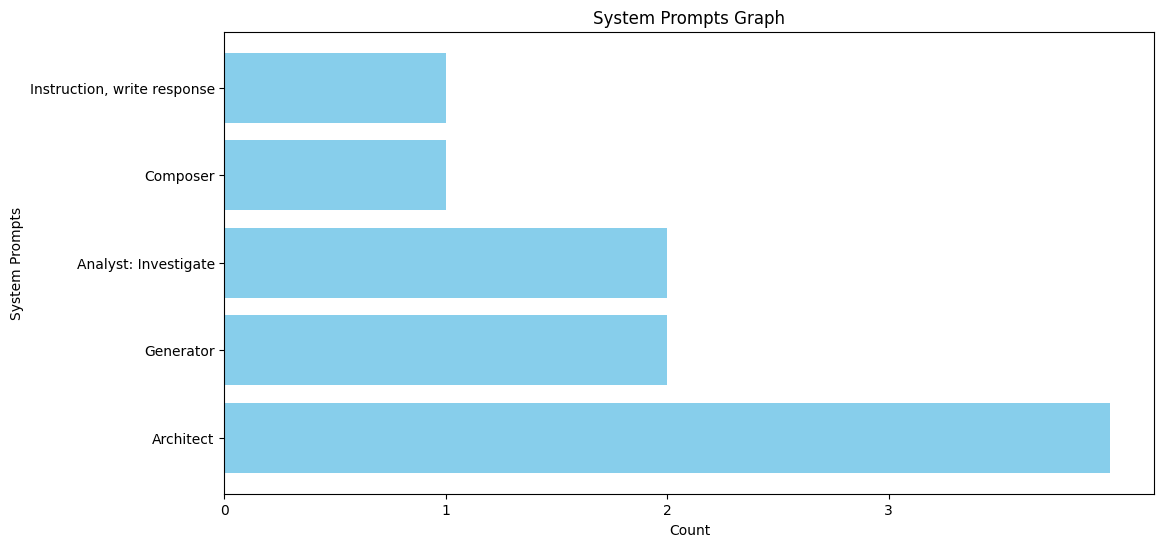

In [30]:
# Get unique systems and print them
unique_systems = sample_data['system'].unique()
#print("Unique systems:", unique_systems)

#Create a value counts DataFrame
system_counts = sample_data['system'].value_counts().reset_index()
print(system_counts)

all_system_names = [
    "Architect", 
    "Generator", 
    "Analyst: Investigate",
    "Composer",
    "Instruction, write response"
]
all_counts = [4, 2, 2, 1, 1]

# Create a horizontal bar plot
plt.figure(figsize=(12, 6))
plt.barh(all_system_names, all_counts, color='skyblue')

# Add titles and labels
plt.title('System Prompts Graph')
plt.xlabel('Count')
plt.ylabel('System Prompts')
ticks_values = range(0, 4, 1)  # Customize tick values from 0 to 900 with step of 100
plt.xticks(ticks=ticks_values)  # Set these ticks on the x-axis
# Show the plot
plt.show()



In [35]:
def average_word_length(series):
    # Split each string in the series into words
    words = series.str.split()
    
    # Calculate total number of words

    total_words = words.apply(len)
    
    # Calculate average number of words
    average_length = total_words.sum() / 10; #Ten rows of data
    return average_length

# Loop through each column and print the average word length for text columns
for column in sample_data.select_dtypes(include=['object']).columns:  # Select only object type columns (text)
    avg_length = average_word_length(sample_data[column])
    print(f'The average word length in column "{column}" is: {avg_length:.2f}')

The average word length in column "output" is: 33.70
The average word length in column "instruction" is: 39.90
The average word length in column "system" is: 11.40


#### Is there a relation between the type of system and the word length of the instruction?

Findings: 

- The mean word length of instructions in the code Generator was the longest.
- but it might not mean alot with just 10 data points

                                                                                 system  \
0          As a Python code analyst, you investigate and solve complex coding mysteries   
1                     As a Python code composer, you craft elegant and concise scripts.   
2                                                           Instruction, write response   
3  You are a Python code architect, reviewing and designing scalable and efficient code   
4     You are a Python code generator, capable of creating scripts from specifications.   

   instruction_word_length  
0                     15.0  
1                     26.0  
2                     10.0  
3                     39.5  
4                     87.5  


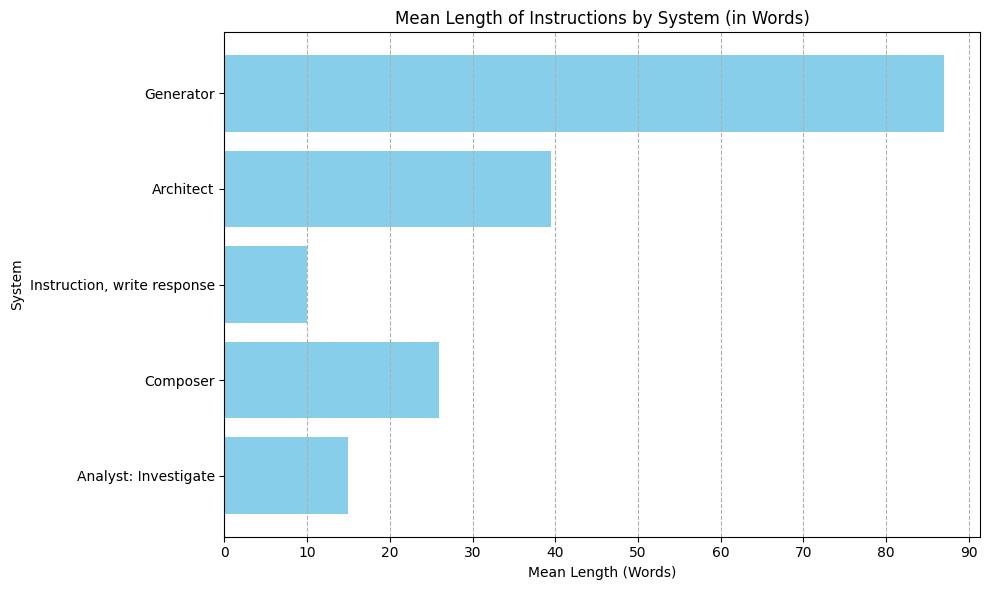

In [32]:
#Calculate word lengths for each instruction
sample_data['instruction_word_length'] = sample_data['instruction'].apply(lambda x: len(x.split()))

#Group by system and calculate the mean word length
mean_word_length_stats = sample_data.groupby('system')['instruction_word_length'].mean().reset_index()
print(mean_word_length_stats)
all_system_names = [
    "Analyst: Investigate",
    "Composer",
    "Instruction, write response",
    "Architect",
    "Generator"
]
mean_inst_length = [15, 26, 10, 39.5, 87]

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(all_system_names, mean_inst_length, color='skyblue')
plt.title('Mean Length of Instructions by System (in Words)')
plt.xlabel('Mean Length (Words)')
plt.ylabel('System')
ticks_values = range(0, 100, 10)  # Customize tick values from 0 to 900 with step of 100
plt.xticks(ticks=ticks_values)  # Set these ticks on the x-axis
plt.grid(axis='x', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()



#### Relationship between the word length of instruction and word length of output

Findings: 

- Not really. 
- But the output is usually shorter than the instructions


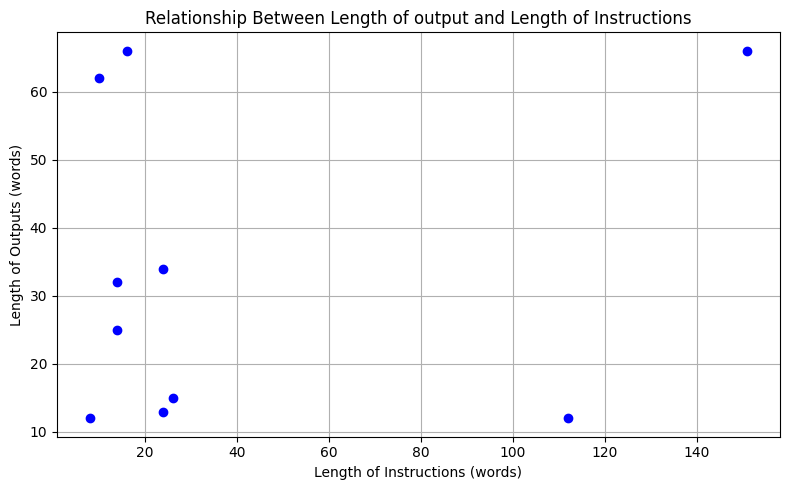

In [36]:
#between the length of the instruction and the length of the output
# Step 1: Calculate lengths of the instructions and systems
sample_data['output_length'] = sample_data['output'].str.split().str.len()
sample_data['instruction_length'] = sample_data['instruction'].str.split().str.len()

# Step 2: Scatter Plot to visualize relationship
plt.figure(figsize=(8, 5))
plt.scatter(sample_data['instruction_length'], sample_data['output_length'], color='blue')
plt.title('Relationship Between Length of output and Length of Instructions')
plt.xlabel('Length of Instructions (words)')
plt.ylabel('Length of Outputs (words)')

plt.grid(True)

plt.tight_layout()
plt.show()

### Data Analysis

Outputs: 
- The outputs for `4` samples were not code. `2` of them were stating what the output of the inputed code would be. One of them was for the system: generator and the other was for code architect. The other `2` were explanations of the code` and the system was code architecht
Inputs: 
- Are a mix of just words and a combination of code and words. 



### Next steps
- Not consider the system, as it doesn't seem to have a lot of relation with the instructions. 
- Parse the input for key words: `Create`, `Python`, `Tell` to predict whether the output would be code or explanation